In [1]:
pip install nltk -U

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pyspark

sc = spark.sparkContext

print('Original spark.driver.maxResultSize: ' + sc._conf.get('spark.driver.maxResultSize'))
sc.stop()

Original spark.driver.maxResultSize: 1920m


# PAUSE for sc to stop

In [3]:
conf = pyspark.SparkConf().setAll([('spark.driver.maxResultSize','4g')])
sc = pyspark.SparkContext(conf=conf)
print('New spark.driver.maxResultSize: ' + sc._conf.get('spark.driver.maxResultSize'))
spark = SparkSession.builder.config(conf=conf).getOrCreate()

22/12/08 02:50:18 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
22/12/08 02:50:18 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
22/12/08 02:50:18 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
22/12/08 02:50:18 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


New spark.driver.maxResultSize: 4g


In [4]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)
from itertools import compress 
from pyspark.sql.types import *
from pyspark.sql import functions as F
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')

In [5]:
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
from pyspark.sql import Window
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [7]:
import os
import subprocess
from pyspark.sql.functions import *
from pyspark.sql.types import *

## loading Checkpoint


In [8]:
pd.set_option('display.max_columns', None)

In [9]:
filtered_tweets = spark.read.parquet("gs://msca-bdp-students-bucket/shared_data/chw387/filtered_tweets2")

In [10]:
gov_users = spark.read.parquet("gs://msca-bdp-students-bucket/shared_data/chw387/gov_users")
news_users = spark.read.parquet("gs://msca-bdp-students-bucket/shared_data/chw387/news_users")
school_users = spark.read.parquet("gs://msca-bdp-students-bucket/shared_data/chw387/school_users")
ngo_users = spark.read.parquet("gs://msca-bdp-students-bucket/shared_data/chw387/ngo_users")
influ_users = spark.read.parquet("gs://msca-bdp-students-bucket/shared_data/chw387/influ_users")

# Prolific Twitterer Visuals

In [76]:
# most original tweets in education space
top100orig = filtered_tweets.groupby('user_id_str').agg(
    F.first('user_name').alias('user_name'),
    F.first('user_desc').alias('user_desc'),
    F.first('location').alias('location'),
    F.first('user_verified').alias('user_verified'),
    F.first('user_rtd_count').alias('user_rtd_count'),
    F.first('user_follow_count').alias('user_follow_count'),
    F.first('num_original_tweets').alias('num_original_tweets'),
    F.first('num_edu_tweets').alias('num_edu_tweets'),
    F.first('total_tweets').alias('total_tweets'),
    F.first('isGov').alias('isGov'),
    F.first('isNews').alias('isNews'),
    F.first('isNgo').alias('isNgo'),
    F.first('isSchool').alias('isSchool'),
    F.first('isInflu').alias('isInflu')
).orderBy('num_original_tweets',ascending=False).limit(100).toPandas()

In [69]:
filtered_tweets.filter(
    (F.col('user_id_str')=='1468164097355264002')&
    (F.col('isRt')==False)
).select('lower_tweet_txt').limit(5).toPandas()

,lower_tweet_txt
0,university of sheffield student wins national nursing award | news https://t.co/6sjansl1se
1,"400 schools in punjab have no teacher, 1,600 have only one: state education minister https://t.co/lh4vsq7puz"
2,best school bags for the new term: cool bags for secondary and primary students https://t.co/kyipuwgrn4
3,is there a new high school musical movie in the works? https://t.co/8kx1qgaj2q
4,letter: thank you to partners in education for supporting newton schools https://t.co/dzlow0q9au


In [58]:
top100orig.head(5)[['user_name','user_desc','num_original_tweets','user_id_str']]

,user_name,user_desc,num_original_tweets,user_id_str
0,NJSchoolJobs.com,The leading advertiser of education jobs for New Jersey's Schools since 1999! #nj #teaching #administrative #coaching #education #teachingjobs #newjersey,9887,66263683
1,kae 🍀,༄༄༄༄༄༄ need funds for school ༝̩̩̥͙ ༓༝̩̩̥͙ ⊹ gaws joiner ⊹༝̩̩̥͙ ༓༝̩̩̥͙ not a multi. NOT A BOT. FREE TAG.,9357,1549115944735481856
2,Dennis Stemmle,"Founder - College Success Academy, #1 Best-Selling Author, Entrepreneur, Speaker, Lecturer at The Wall College of Business - Coastal Carolina University",8411,219401992
3,KQ education group,THIS WEBSITE PROVIDE LATEST NEWS ON EDUCATION. Continue To help US FOR LATEST NEWS AND WE WILL PROVIDE BEST OF OUR EFFORTS TO MAKE YOU UPDATED,6162,1468164097355264002
4,Kevin Edwards,Special Education teacher who loves teaching and making fun memories in the classroom!\n\nCash App: $kpe0712,3113,1408202907149815809


Text(0.5, 0, 'count')

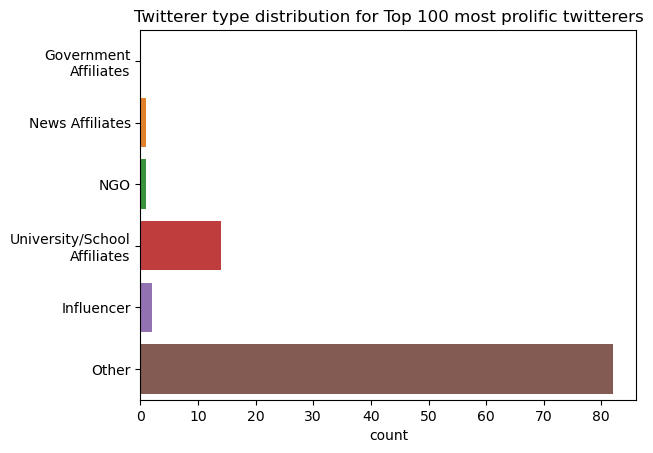

In [97]:
origSer = top100orig[['isGov','isNews','isNgo','isSchool','isInflu']].sum()
origSer = pd.concat([origSer,pd.Series(100-origSer.sum())])
origSer.index = ['Government\nAffiliates','News Affiliates','NGO','University/School\nAffiliates','Influencer','Other']
ax = sns.barplot(y=origSer.index,x=origSer)
ax.set_title('Twitterer type distribution for Top 100 most prolific twitterers')
ax.set_xlabel('count')

In [73]:
filtered_tweets.filter(
    (F.col('user_id_str')=='1268223690480615424')&
    (F.col('isRt')==False)
).select('lower_tweet_txt').limit(5).toPandas()

,lower_tweet_txt
0,"new: senator cynthia lummis (r–wy) was booed and told to get off stage when she spouted anti-lgbtq rhetoric during a commencement speech at the university of wyoming. it’s the same university gay student matthew shepard attended when he was beaten, tortured, and left to die."
1,"new: senator cynthia lummis (r–wy) was booed and told to get off stage by students for spouting anti-lgbtq rhetoric during a commencement speech at the university of wyoming. it’s the same university matthew shepard attended when he was beaten, tortured, and left to die in 1998."
2,"new: texas a&amp;m university just said that they have not accepted kyle rittenhouse as a student after rittenhouse announced he will be going there for school, per @texastribune."
3,republican senator roger marshall of kansas is threatening to let children go hungry by blocking funding for school lunches unless they allow lgbtq students to be discriminated against. this is what the republican party stands for.
4,"the florida gop has passed don’t say gay, increased punishments for protesting, censored how employers can discuss race, made it easier to ban books, required schools to forcibly out students to their families, and gone after disney for having a different opinion.\n\n“free speech.”"


In [75]:
# most original tweets in education space
top100rt = filtered_tweets.groupby('user_id_str').agg(
    F.first('user_name').alias('user_name'),
    F.first('user_desc').alias('user_desc'),
    F.first('location').alias('location'),
    F.first('user_verified').alias('user_verified'),
    F.first('user_rtd_count').alias('user_rtd_count'),
    F.first('user_follow_count').alias('user_follow_count'),
    F.first('num_original_tweets').alias('num_original_tweets'),
    F.first('num_edu_tweets').alias('num_edu_tweets'),
    F.first('total_tweets').alias('total_tweets'),
    F.first('isGov').alias('isGov'),
    F.first('isNews').alias('isNews'),
    F.first('isNgo').alias('isNgo'),
    F.first('isSchool').alias('isSchool'),
    F.first('isInflu').alias('isInflu')
).orderBy('user_rtd_count',ascending=False).limit(100).toPandas()

In [64]:
top100rt.head(5)

,user_id_str,user_name,user_desc,location,user_verified,user_rtd_count,user_follow_count,num_original_tweets,num_edu_tweets,total_tweets,isGov,isNews,isSchool,isInflu
0,1326229737551912960,Libs of TikTok,All videos belong to their respective owners. 📧 libsoftiktok@gmail.com. DM submissions. This post is for Telegram. I want to get the username https://t.co/oTCGGJDvgh,Depths of Hell,False,167290,1482265,111,139,9059,False,False,False,True
1,878284831,Occupy Democrats,Grassroots political organization & news website supporting progressive Democrats. NY Times reported that our reach dominated Trump on Facebook before his ban.,United States,True,59812,500212,23,36,99494,True,True,False,False
2,3066800573,Christopher F. Rufo ⚔️,"Writer, filmmaker, activist. @ManhattanInst and @CityJournal. Married to @skprufo. Views mine. Newsletter: http://christopherrufo.com/newsletter.",Tips: chrisrufo@protonmail.com,True,41818,417918,82,118,15591,False,True,False,False
3,1268223690480615424,No Lie with Brian Tyler Cohen,Podcast covering the top stories & interviews with the biggest names in politics. Hosted by @briantylercohen,"Los Angeles, CA",True,38845,283323,11,17,5969,False,False,False,True
4,242113465,Scorpiio,"Love irrationally, Love radically 🧘🏼‍♂️ route-setter 🧗🏼‍♂️ (he/him) @detwillbreathe | General Baker Institute | @313ccDetroit ✊🏼","Detroit, MI",False,34063,1608,1,1,10672,False,False,False,False


In [93]:
100-rtSer.sum()

13

In [95]:
pd.concat([rtSer,pd.Series(100-rtSer.sum())])

Government\nAffiliates           10
News Affiliates                  15
NGO                               1
University/School\nAffiliates     7
Influencer                       54
0                                13
dtype: int64

Text(0.5, 0, 'count')

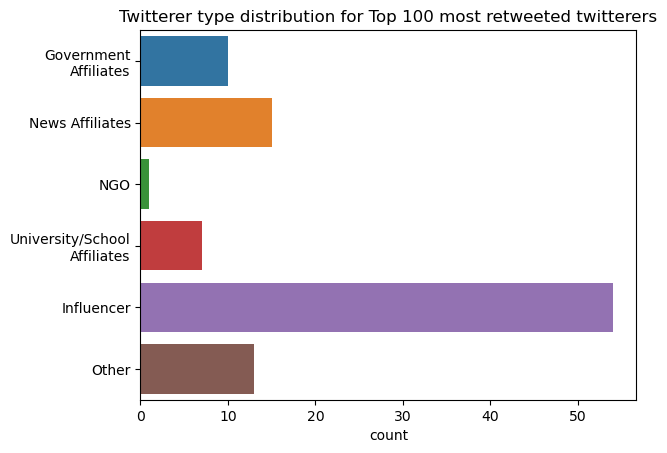

In [96]:
rtSer = top100rt[['isGov','isNews','isNgo','isSchool','isInflu']].sum()
rtSer = pd.concat([rtSer,pd.Series(100-rtSer.sum())])
rtSer.index = ['Government\nAffiliates','News Affiliates','NGO','University/School\nAffiliates','Influencer','Other']
ax = sns.barplot(y=rtSer.index,x=rtSer)
ax.set_title('Twitterer type distribution for Top 100 most retweeted twitterers')
ax.set_xlabel('count')

# Types of twitterers

In [41]:
user_type_counts = pd.Series([
    (school_users.count()),
    (gov_users.count()),
    (news_users.count()),
    (ngo_users.count()),
    (influ_users.count())
],index=[
    'University/School Affiliates','Government Affiliates',
    'News Affiliates','NGO Accounts','Influencers'
],name='User Type Counts').sort_values()

In [42]:
filtered_tweets.select('user_id_str').distinct().count()

7056456

In [39]:
user_type_counts.sum()/8901342 #= total users tweeting abt education

0.04014675539935439

Text(0.5, 1.0, 'Number of Users Per Identified Categories')

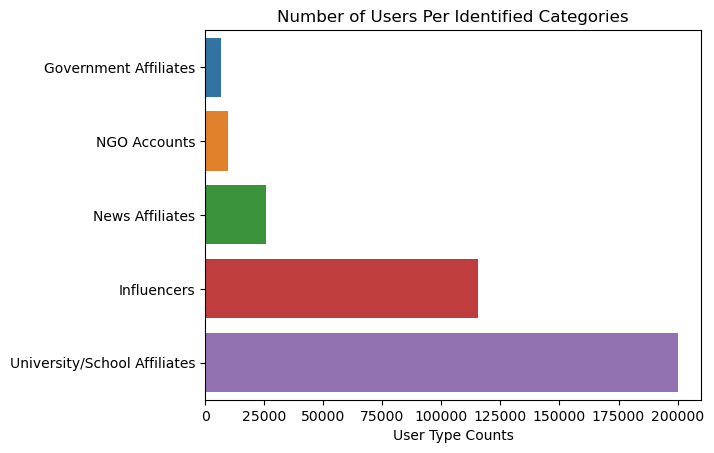

In [42]:
ax = sns.barplot(y=user_type_counts.index,x=user_type_counts)
ax.set_title('Number of Users Per Identified Categories')

# visualize tweet/retweet counts

In [ ]:
def pysparkHist(sparkDf,title='',xlabel='',line_label='',
                log=None,axes=None,bins=30,untrans_func=None,*,col_name)->None:
    if log is None:
        col = (
            sparkDf
            .filter(~F.col(col_name).isNull())
            .select(col_name)
        )
    else:
        col = (
            sparkDf
            .filter(~F.col(col_name).isNull())
            .select(F.log(10.0,col_name))
        )
    
    buckets, counts = (
        col
        .rdd.flatMap(lambda x: x)
        .histogram(bins)
    )
    if axes is None:
        ax = sns.lineplot(x=buckets[:-1],y=counts,label=line_label)
        axes=ax
    else:
        sns.lineplot(x=buckets[:-1],y=counts,ax=axes,label=line_label)
    if log is not None:
        axes.set_xticklabels([int(i) for i in log**axes.get_xticks()],rotation=45)
    elif untrans_func is not None:
        axes.set_xticklabels(untrans_func(axes.get_xticks()),rotation=45)
        
    axes.set_title(title)
    axes.set_xlabel(xlabel)
    axes.set_ylabel('Counts')
    return axes

In [106]:
filtered_tweets.filter(
    (F.col('isGov')==False)&
    (F.col('isNews')==False)&
    (F.col('isSchool')==False)&
    (F.col('isInflu')==False)
).count()

22395278

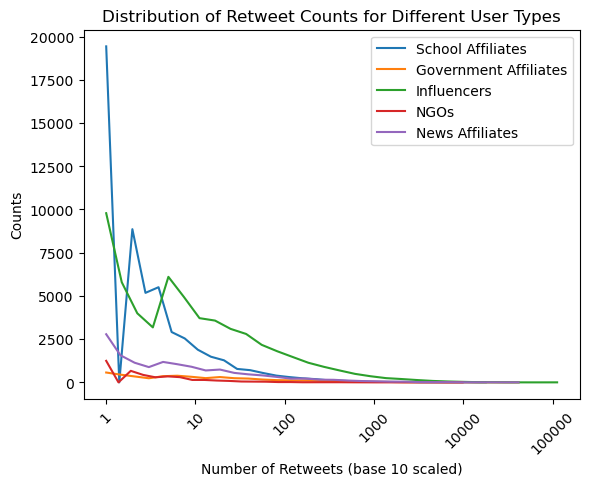

In [ ]:
ax = pysparkHist(
    school_users,
    log=10,
    line_label='School Affiliates',
    col_name='user_rtd_count'
)
pysparkHist(
    gov_users,
    axes=ax,
    log=10,
    line_label='Government Affiliates',
    col_name='user_rtd_count'
)
pysparkHist(
    influ_users,
    axes=ax,
    log=10,
    line_label='Influencers',
    col_name='user_rtd_count'
)
pysparkHist(
    ngo_users,
    axes=ax,
    log=10,
    line_label='NGOs',
    col_name='user_rtd_count'
)
pysparkHist(
    news_users,
    title='Distribution of Retweet Counts for Different User Types',
    xlabel='Number of Retweets (base 10 scaled)',
    axes=ax,
    log=10,
    line_label='News Affiliates',
    col_name='user_rtd_count'
)

ax.legend()

# Timeline

In [83]:
from datetime import datetime 

In [15]:
monthCounts = filtered_tweets.withColumn(
    "month",
    F.month('created_at')
).withColumn(
    "day",
    F.dayofmonth('created_at')
).groupby(['month','day']).agg(
    F.first('created_at').alias('created_timestamp'),
    F.count('created_at').alias('counts')
).toPandas()
monthCounts = monthCounts.sort_values('month')

In [74]:
dowCounts = filtered_tweets.withColumn(
    "dow",
    F.dayofweek('created_at')
).groupby('dow').count().toPandas()
dowCounts = dowCounts.sort_values('dow')

In [73]:
filtered_tweets.withColumn(
    "date_type",to_date('created_at')
).withColumn(
    "dow",
    F.dayofweek('created_at')
).groupby('dow').agg(
    F.countDistinct('date_type')
).toPandas()

,dow,count(date_type)
0,1,31
1,6,31
2,3,31
3,5,31
4,4,31
5,7,31
6,2,30


In [75]:
# basically the same so we don't need to normalize
dowCounts = dowCounts.reset_index()
dowCounts['dowName'] = pd.Series(['Mon','Tues','Wed','Thurs','Fri','Sat','Sun'])

Text(0.5, 0, 'Day of Week')

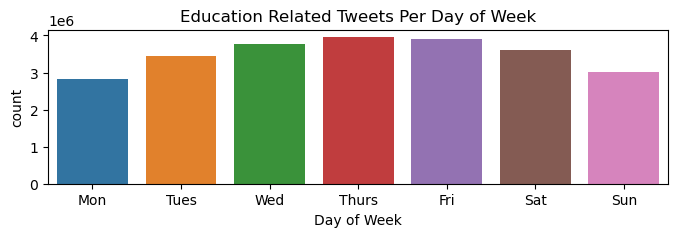

In [85]:
plt.figure(figsize=(8,2))
ax = sns.barplot(x=dowCounts['dowName'],y=dowCounts['count'])
ax.set_title('Education Related Tweets Per Day of Week')
ax.set_xlabel('Day of Week')

Text(0.5, 0, 'Dates')

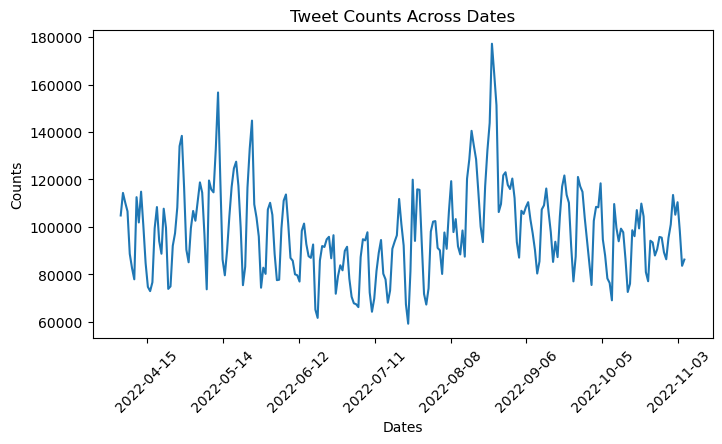

In [84]:
plt.figure(figsize=(8,4))
ax = pysparkHist(
    filtered_tweets.select(
        F.unix_timestamp('created_at', 'yyyy-MM-dd HH:mm:ss').alias('unix_time')
    ),
    bins=250,
    untrans_func=lambda x: [datetime.utcfromtimestamp(i).strftime('%Y-%m-%d') for i in x],
    col_name='unix_time'
)
ax.set_title('Tweet Counts Across Dates')
ax.set_xlabel('Dates')

# Location

In [314]:
import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoDataFrame
pd.set_option('display.max_rows',30)

In [315]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/miniconda3/share/proj failed


In [322]:
coords = filtered_tweets.filter(
    F.col('place').isNotNull()
).groupby('user_id_str').agg(
    F.first('place').alias('place'),
    F.first('isGov').alias('isGov'),
    F.first('isGov').alias('isNews'),
    F.first('isGov').alias('isSchool'),
    F.first('isGov').alias('isNgo'),
    F.first('isGov').alias('isInflu')
).select(
    F.col('place').bounding_box.coordinates[0][0].alias('coords'),
    F.col('isGov'),
    F.col('isNews'),
    F.col('isSchool'),
    F.col('isNgo'),
    F.col('isInflu')
).distinct().toPandas()
coords2 = pd.DataFrame(coords.coords.tolist(),columns=['lon','lat'])
geometry = [ Point(xy) for xy in zip(coords2.lon,coords2.lat)]
coords3 = GeoDataFrame(coords2,crs="EPSG:4326",geometry=geometry)

[Text(0.5, 87.71249958306291, 'Longitude'),
 Text(35.347222222222214, 0.5, 'Latitude')]

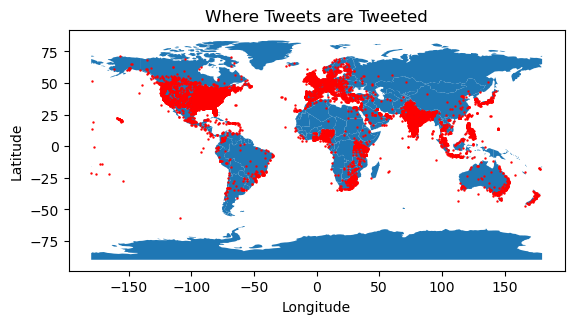

In [35]:
ax = world.plot()
coords2.plot(ax=ax,color='red',markersize=0.5)
ax.set_title('Where Tweets are Tweeted')
ax.set(xlabel='Longitude', ylabel='Latitude')

In [342]:
genLocs = filtered_tweets.filter(
    F.col('place').isNotNull()
).select(
    F.col('place').country.alias('country')
).groupby('country').count().toPandas()

In [343]:
genLocs['pct'] = genLocs['count']/genLocs['count'].sum()

[Text(0.0, 0, '0%'),
 Text(0.1, 0, '10%'),
 Text(0.2, 0, '20%'),
 Text(0.30000000000000004, 0, '30%'),
 Text(0.4, 0, '40%'),
 Text(0.5, 0, '50%'),
 Text(0.6000000000000001, 0, '60%'),
 Text(0.7000000000000001, 0, '70%'),
 Text(0.8, 0, '80%')]

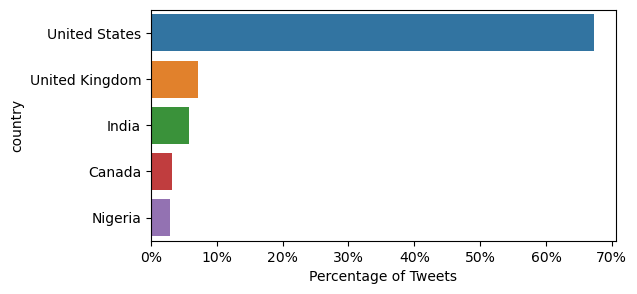

In [345]:
genLocs = genLocs.sort_values('count',ascending=False).head(5)
plt.figure(figsize=(6,3))
ax = sns.barplot(y=genLocs['country'],x=genLocs['pct'])
ax.set_xlabel('Percentage of Tweets')
ax.set_xticklabels([f'{i*100:.0f}%' for i in ax.get_xticks()])

# gender sexuality tweet locations

In [316]:
coords = filtered_tweets.filter(
    F.col('place').isNotNull() &
    (
        F.col('lower_tweet_txt').contains('gender')|
        F.col('lower_tweet_txt').contains('sex')|
        F.col('lower_tweet_txt').contains('lgbt')
    )
).groupby('user_id_str').agg(
    F.first('place').alias('place')
).select(
    F.col('place').bounding_box.coordinates[0][0].alias('coords')
).distinct().toPandas()
coords = pd.DataFrame(coords.coords.tolist(),columns=['lon','lat'])
geometry = [ Point(xy) for xy in zip(coords.lon,coords.lat)]
coords = GeoDataFrame(coords,crs="EPSG:4326",geometry=geometry)

[Text(0.5, 85.75300071516976, 'Longitude'),
 Text(35.347222222222214, 0.5, 'Latitude')]

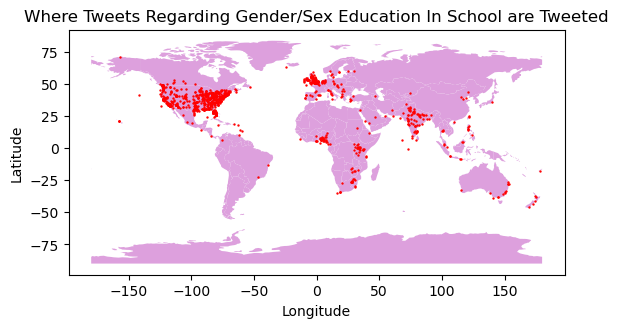

In [108]:
ax = world.plot(color='plum')
coords.plot(ax=ax,color='red',markersize=0.5)
ax.set_title('Where Tweets Regarding Gender/Sex Education In School are Tweeted')
ax.set(xlabel='Longitude', ylabel='Latitude')

In [336]:
lgbtLocs = filtered_tweets.filter(
    F.col('place').isNotNull()&
    (
        F.col('lower_tweet_txt').contains('gender')|
        F.col('lower_tweet_txt').contains('sex')|
        F.col('lower_tweet_txt').contains('lgbt')
    )
).select(
    F.col('place').country.alias('country')
).groupby('country').count().toPandas()

In [338]:
lgbtLocs['pct'] = lgbtLocs['count']/lgbtLocs['count'].sum()

[Text(0.0, 0, '0%'),
 Text(0.1, 0, '10%'),
 Text(0.2, 0, '20%'),
 Text(0.30000000000000004, 0, '30%'),
 Text(0.4, 0, '40%'),
 Text(0.5, 0, '50%'),
 Text(0.6000000000000001, 0, '60%'),
 Text(0.7000000000000001, 0, '70%'),
 Text(0.8, 0, '80%')]

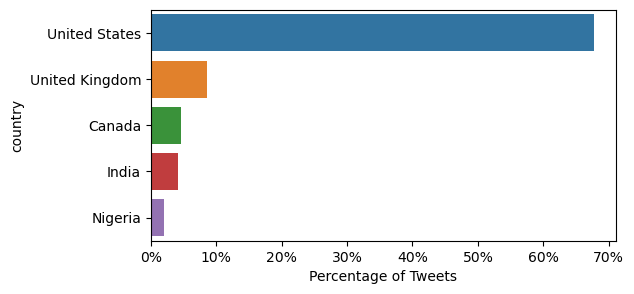

In [340]:
lgbtLocs = lgbtLocs.sort_values('pct',ascending=False).head(5)
plt.figure(figsize=(6,3))
ax = sns.barplot(y=lgbtLocs['country'],x=lgbtLocs['pct'])
ax.set_xlabel('Percentage of Tweets')
ax.set_xticklabels([f'{i*100:.0f}%' for i in ax.get_xticks()])

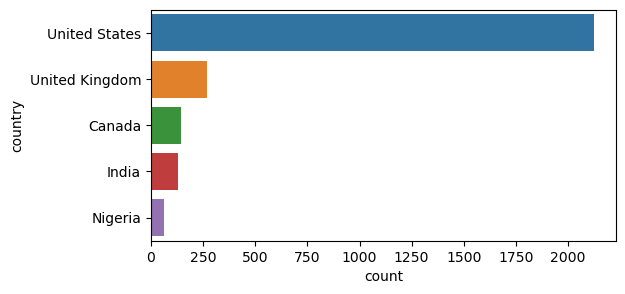

In [42]:
lgbtLocs = lgbtLocs.sort_values('count',ascending=False).head(5)
plt.figure(figsize=(6,3))
ax = sns.barplot(y=lgbtLocs['country'],x=lgbtLocs['count'])

# Text similarity lsh

In [164]:
# I.I.D Randomly sample 1% of the data
# otherwise dataset is too large to run and later cache
origTweets = filtered_tweets.filter(
    (F.col('isRt')==False)
).sample(fraction=0.01)

In [166]:
# has similar number of tweets as the highest user group "school users"
sampFrac = 10000/origTweets.count()

In [167]:
origTweets = origTweets.sample(fraction=sampFrac)

Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.ServerSocket.implAccept(ServerSocket.java:560)
	at java.net.ServerSocket.accept(ServerSocket.java:528)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


In [168]:
StopWords = stopwords.words("english")
text = origTweets.rdd.map(lambda x : x['lower_tweet_txt']).filter(lambda x: x is not None)
tokens = text\
    .map( lambda document: document.strip())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if x.isalnum()])\
    .map( lambda word: [x for x in word if len(x) > 3] )\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .zipWithIndex()

In [169]:
row = Row('lower_tweet_txt_lst')
df_text = text.map(row).zipWithIndex().toDF(['lower_tweet_txt_lst','id'])
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=6)
model = mh.fit(df_vectorize)

In [170]:
df_hashed = mh.fit(df_vectorize).transform(df_vectorize)
df_hashed_text = df_text.join(df_hashed, "id", how = 'left').cache()

In [180]:
jaccard_distance = 0.6
df_dups_text = model.approxSimilarityJoin(
    inter, inter, jaccard_distance
).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.lower_tweet_txt_lst').alias('text_A'),
            col('datasetB.lower_tweet_txt_lst').alias('text_B')
)
 

In [181]:
records = df_hashed_text.count() 
dups = df_dups_text.select('id_A').distinct().count() 
uniques = records - dups 

In [182]:
genTweetSimilarityResult60p = {'near_dups': dups, 'unique': uniques,'records':records}

In [183]:
genTweetSimilarityResult20p,genTweetSimilarityResult40p,genTweetSimilarityResult60p

({'near_dups': 1316, 'unique': 8693, 'records': 10009},
 {'near_dups': 2308, 'unique': 7701, 'records': 10009},
 {'near_dups': 5717, 'unique': 4292, 'records': 10009})

In [22]:
df_hashed_text.unpersist()

id,lower_tweet_txt_lst,list_of_words,features,hashes
670,{ni education: ex...,"[exam, board, apo...","(51441,[2,7,25,66...","[[2.49282241E8], ..."
1036,{@pynchay exactly...,"[exactly, like, r...","(51441,[0,1,4,59,...","[[4.7945584E7], [..."
1070,"{""uh youre um a f...","[youre, really, d...","(51441,[0,1,41,24...","[[4.7945584E7], [..."
1552,{@shaq @authentic...,"[hello, shaq, uni...","(51441,[0,6,7,22,...","[[4.7945584E7], [..."
2023,{the guy in your ...,"[high, school, cl...","(51441,[0,1,14,37...","[[1.4642722E7], [..."
2075,{@jim_jordan noth...,"[nothing, jordan,...","(51441,[2,3,79,18...","[[1.73591059E8], ..."
2777,{when i was 11 me...,"[bestie, would, t...","(51441,[0,10,12,2...","[[4.7945584E7], [..."
2823,{6 days to go unt...,"[days, race, char...","(51441,[35,55,57,...","[[1.04460723E8], ..."
2863,{@climatewarrior7...,"[thank, much, pro...","(51441,[7,44,55,5...","[[7.1157861E7], [..."
2872,{graduate school ...,"[graduate, school...","(51441,[0,6,50,38...","[[4.7945584E7], [..."


In [188]:
# check jacc sim threshold
pandasView = df_dups_text.filter(
    (F.col('distCol')>=0.5)&
    (F.col('distCol')<=0.6)
).sample(fraction = 0.25).limit(25).toPandas()
pandasView

,distCol,id_A,id_B,text_A,text_B
0,0.500000,6186,52080,"(@korienotcory u peaked in high school,)","(@heenaar_08 high school musical,)"
1,0.500000,16608,75331,"(@sangaymishra high school us history,)","(@autumnfoster @cnn i had that t shirt in high school,)"
2,0.571429,35448,64761,"(@az_brittney when i was a carryout while in high school i used to,)","(@deesnider agnostic front i used to listen to in high school lol,)"
3,0.500000,56738,74807,"(@laurenboebert #laurenboebert was this your high school ged failure class picture? https://t.co/titzidm3bl,)","(@derbydada @shai_isthe_goat @chan_the_world #airbnb ➡ co-founder #gifts high school #graduates with #stock (published may 26, 2022)\nhttps://t.co/47j2disrh8,)"
4,0.500000,18771,28537,"(#canada’s pm here looks like a high school kid, eh?,)","(🥖: i'm so hungry. what do you wanna have, arisa?\n🌱: huh…\n🥖: what’s up?\n🌱: we're like real high school girls...\n🥖: ... pff...,)"
5,0.500000,29890,43352,"(thornwood mf high school,)","(what the fuck was high school,)"
6,0.500000,42760,76166,"(@mrozinskax high school musical,)","(they knew me as the “trap lord” in high school,)"
7,0.500000,50340,73278,"(can i skip high school and college,)","(@itssirberus ain’t no way you in high school man,)"
8,0.500000,54157,62310,"(reminds me of my high school sweetheart!,)","(@williambradycos @briangaar strong point, ex-military high school teacher.,)"
9,0.500000,9475,41129,"(what is the differencebetween middle school and junior highschool.....,)","(middle school ass fit 😂😂,)"


# Intragroup sim

['isGov','isNews','isSchool','isNgo','isInflu']

In [150]:
userGroup = filtered_tweets.filter(
    F.col('isGov') &
    (F.col('isRt')==False)
)

In [151]:
#make sure around 10k
sampFrac = 10000/userGroup.count()

In [152]:
userGroup = userGroup.sample(fraction=sampFrac)

In [153]:
StopWords = stopwords.words("english")
text = userGroup.rdd.map(lambda x : x['lower_tweet_txt']).filter(lambda x: x is not None)
tokens = text\
    .map( lambda document: document.strip())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if x.isalnum()])\
    .map( lambda word: [x for x in word if len(x) > 3] )\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .zipWithIndex()

In [154]:
row = Row('lower_tweet_txt_lst')
df_text = text.map(row).zipWithIndex().toDF(['lower_tweet_txt_lst','id'])
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize)

In [155]:
df_hashed_text = df_text.join(df_hashed, "id", how = 'left').cache()

In [160]:
jaccard_distance = 0.6
df_dups_text = model.approxSimilarityJoin(
    df_hashed_text, df_hashed_text, jaccard_distance
).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.lower_tweet_txt_lst').alias('text_A'),
            col('datasetB.lower_tweet_txt_lst').alias('text_B')
)

In [161]:
records = df_hashed_text.count() 
dups = df_dups_text.select('id_A').distinct().count() 
uniques = records - dups 

In [162]:
govTweetSimilarityResult60p = {'near_dups': dups, 'unique': uniques,'records':records}

In [90]:
df_hashed_text.unpersist()

id,lower_tweet_txt_lst,list_of_words,features,hashes
26,{our virtual japa...,"[virtual, japanes...","(16565,[4,18,67,2...","[[3.24973423E8], ..."
29,{partnering with ...,"[partnering, annu...","(16565,[0,8,10,37...","[[4.7945584E7], [..."
65,{send a displaced...,"[send, displaced,...","(16565,[0,2,7,10,...","[[3.331227E7], [1..."
191,{kids at the gove...,"[kids, government...","(16565,[15,48,96,...","[[3547010.0], [2...."
19,{more than a thou...,"[thousand, school...","(16565,[0,13,45,9...","[[4.7945584E7], [..."
54,{today we payed ...,"[today, payed, co...","(16565,[0,15,26,2...","[[3.331227E7], [2..."
0,{help replenish o...,"[help, replenish,...","(16565,[1,8,10,14...","[[1.04460723E8], ..."
112,{it's homecoming ...,"[homecoming, take...","(16565,[1,4,7,8,1...","[[1.19094037E8], ..."
113,{congratulations ...,"[congratulations,...","(16565,[5,24,53,7...","[[6.0560781E7], [..."
155,{did you know str...,"[know, strm, disa...","(16565,[4,12,20,3...","[[2.46757629E8], ..."


In [77]:
# check jacc sim threshold
pandasView = df_dups_text.filter(
    F.col('distCol')>=0.35
).sample(fraction = 0.25).limit(25).toPandas()
pandasView

,distCol,id_A,id_B,text_A,text_B
0,0.375000,3202,8787,"(@ape_psycho the furries are arriving! \nbe 1st buyer to start the collection &amp; receive 1 bonus free nft \nfuture random suprises for buyers! \nrandom suprises for some resales!\ni am a high school art teacher spreading wings.\nhttps://t.co/fgxvzi5pxn\nhttps://t.co/v6de19yqnl #womenin_nfts,)","(@nft_enthusiasts the furries are arriving! \nbe 1st buyer to start the collection to receive 1 bonus:free nft no gas fees polygon\nfuture suprises for buyers! 0.004eth/polygon \ni am a high school art teacher spreading wings.\nhttps://t.co/bsxdoqgba9 out this item on opensea https://t.co/9iwodsuflq,)"
1,0.384615,4461,4464,"(@mrstomanek @amazon these books! school starts next week!! i’m trying to #clearthelist for my k-2nd students at our title 1 school! would love some books to build our classroom library! #teacher #teachertwitter #bettertogether #backtoschool2022 #backtoschool https://t.co/wotoz76j72 https://t.co/gfgsfd1l6q,)","(@niknike09 school started 2 months ago! i’m trying to #clearthelist for my k-2nd students at a title 1 school! would love books for a classroom library! #teachertwitter #bettertogether #backtoschool2022 #backtoschool #clearthelists #clearthelists2022 #adoptateacher https://t.co/wotoz7ntya https://t.co/mpm6ffkqwc,)"
2,0.363636,5256,9381,"(@clearinglists @amazon @donorschoose fifth grade teacher from a title i school here! i would love help with my donors choose. i have $186 to meet my goal! 📚❤️📚❤️ https://t.co/zagvugvooq,)","(@brittanylynne ☀️good morning☀️\n\ni’m a 2nd grade teacher 👩‍🏫 from a title 1 school in #michigan &amp; would love ❤️ some help to #clearthelist #twitterteacher #adoptateacher \n✏️ pencils\n✂️glue sticks\n🔬stem morning bin supplies\n🍿snacks\n📖 books\n\nhttps://t.co/iwydtmgoa7 https://t.co/2cmxckrpfo,)"
3,0.375000,765,869,"(hey @verizon! i am a first grade teacher at a low income school in nebraska. can you help me #clearthelist?! https://t.co/vtosw0ujol https://t.co/hc0x9axmqx,)","(@pearltheceo thank you! first grade teacher at a title 1 school in kansas. any help is appreciated! #clearthelist https://t.co/a93oaxqzz5,)"
4,0.384615,4458,4461,"(@msamandaslp school started 5 weeks ago! i’m trying to #clearthelist for my k-2nd students at a title 1 school! would love books for a classroom library! #teachertwitter #bettertogether #backtoschool2022 #backtoschool #clearthelists #clearthelists2022 #adoptateacher https://t.co/wotoz76j72 https://t.co/emt2wzakqs,)","(@mrstomanek @amazon these books! school starts next week!! i’m trying to #clearthelist for my k-2nd students at our title 1 school! would love some books to build our classroom library! #teacher #teachertwitter #bettertogether #backtoschool2022 #backtoschool https://t.co/wotoz76j72 https://t.co/gfgsfd1l6q,)"
5,0.375000,6494,6498,"(@clearinglists thank you for doing this💞 i’m a kindergarten teacher at a title 1 school in nc!! anything helps! https://t.co/sd0opge4ee,)","(@reading8rainbow @amazon i love this!! i’m a kindergarten teacher at a title one school in nc, going into my 5th year. anything at all, helps💞💞💞 https://t.co/sd0opge4ee,)"
6,0.363636,5256,9384,"(@clearinglists @amazon @donorschoose fifth grade teacher from a title i school here! i would love help with my donors choose. i have $186 to meet my goal! 📚❤️📚❤️ https://t.co/zagvugvooq,)","(@techmidschteach ☀️good morning☀️\n\ni’m a 2nd grade teacher 👩‍🏫 from a title 1 school in #michigan &amp; would love ❤️ some help to #clearthelist #twitterteacher #adoptateacher \n✏️ pencils\n✂️glue sticks\n🔬stem morning bin supplies\n🍿snacks\n📖 books\n\nhttps://t.co/iwydtmgoa7 https://t.co/elufzxisz7,)"
7,0.384615,7883,7887,"(@loudphillips can you help #clearthelist and rt my classroom wish list?! second year teacher at a title 1 school in mi teaching grades k-4. any help is so appreciated! https://t.co/nhwnzgfnew #teachertwitter #clearthelists #johnclearmylist https://t.co/sjkapgeysq,)","(@letsplayprek @amazon @donorschoose thank you f

In [34]:
df_hashed_text.unpersist()

id,lower_tweet_txt_lst,list_of_words,features,hashes
26,{whatever your ra...,"[whatever, every,...","(23762,[0,24,85,9...","[[4.7945584E7], [..."
29,{it has been a ge...,"[genuine, privile...","(23762,[3,9,11,12...","[[9408.0], [1.409..."
65,{in some rural di...,"[rural, school, c...","(23762,[0,1,3,5,2...","[[2.9276036E7], [..."
191,{the people who w...,"[people, want, tu...","(23762,[2,4,7,23,...","[[3.59787907E8], ..."
222,{scott jensen is ...,"[scott, jensen, p...","(23762,[0,2,3,5,4...","[[4.7945584E7], [..."
270,{for most rural g...,"[rural, difficult...","(23762,[0,40,78,2...","[[4.7945584E7], [..."
293,{solving the achi...,"[solving, achieve...","(23762,[0,10,14,4...","[[1.8678956E7], [..."
243,{the city's pavin...,"[paving, contract...","(23762,[0,4,72,65...","[[3.0795521E7], [..."
278,"{to the students,...","[others, recently...","(23762,[3,84,221,...","[[1.68051066E8], ..."
19,{we need good sch...,"[need, good, scho...","(23762,[0,3,14,21...","[[4.7945584E7], [..."


In [163]:
govTweetSimilarityResult20p,govTweetSimilarityResult40p,govTweetSimilarityResult60p

({'near_dups': 256, 'unique': 9792, 'records': 10048},
 {'near_dups': 339, 'unique': 9686, 'records': 10025},
 {'near_dups': 530, 'unique': 9518, 'records': 10048})

In [202]:
govDf = pd.DataFrame([govTweetSimilarityResult20p,govTweetSimilarityResult40p,govTweetSimilarityResult60p],index=[0.2,0.4,0.6])
newsDf = pd.DataFrame([newsTweetSimilarityResult20p,newsTweetSimilarityResult40p,newsTweetSimilarityResult60p],index=[0.2,0.4,0.6])
schoolDf = pd.DataFrame([schoolTweetSimilarityResult20p,schoolTweetSimilarityResult40p,schoolTweetSimilarityResult60p],index=[0.2,0.4,0.6])
ngoDf = pd.DataFrame([ngoTweetSimilarityResult20p,ngoTweetSimilarityResult40p,ngoTweetSimilarityResult60p],index=[0.2,0.4,0.6])
influDf = pd.DataFrame([influTweetSimilarityResult20p,influTweetSimilarityResult40p,influTweetSimilarityResult60p],index=[0.2,0.4,0.6])
genDf = pd.DataFrame([genTweetSimilarityResult20p,genTweetSimilarityResult40p,genTweetSimilarityResult60p],index=[0.2,0.4,0.6])

In [219]:
govDf['group'] = 'gov'
newsDf['group'] = 'news'
schoolDf['group'] = 'school'
ngoDf['group'] = 'ngo'
influDf['group'] = 'influencer'
genDf['group'] = 'other'
stackedDf = pd.concat([govDf,newsDf,schoolDf,ngoDf,influDf,genDf])
stackedDf['dupsPct'] = stackedDf.near_dups/stackedDf.records

[Text(0, 0.0, '0%'),
 Text(0, 0.1, '10%'),
 Text(0, 0.2, '20%'),
 Text(0, 0.30000000000000004, '30%'),
 Text(0, 0.4, '40%'),
 Text(0, 0.5, '50%'),
 Text(0, 0.6000000000000001, '60%')]

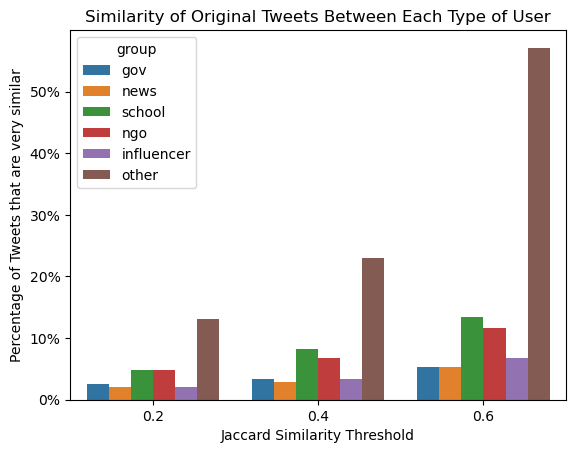

22/12/08 04:25:17 WARN org.apache.spark.storage.BlockManagerMasterEndpoint: No more replicas available for rdd_1044_115 !
22/12/08 04:25:17 WARN org.apache.spark.storage.BlockManagerMasterEndpoint: No more replicas available for rdd_854_139 !
22/12/08 04:25:17 WARN org.apache.spark.storage.BlockManagerMasterEndpoint: No more replicas available for rdd_963_169 !
22/12/08 04:25:17 WARN org.apache.spark.storage.BlockManagerMasterEndpoint: No more replicas available for rdd_1044_66 !
22/12/08 04:25:17 WARN org.apache.spark.storage.BlockManagerMasterEndpoint: No more replicas available for rdd_714_16 !
22/12/08 04:25:17 WARN org.apache.spark.storage.BlockManagerMasterEndpoint: No more replicas available for rdd_963_111 !
22/12/08 04:25:17 WARN org.apache.spark.storage.BlockManagerMasterEndpoint: No more replicas available for rdd_714_53 !
22/12/08 04:25:17 WARN org.apache.spark.storage.BlockManagerMasterEndpoint: No more replicas available for rdd_1044_14 !
22/12/08 04:25:17 WARN org.apache

In [222]:
ax = sns.barplot(x=stackedDf.index,y=stackedDf.dupsPct,hue=stackedDf.group)
ax.set_title('Similarity of Original Tweets Between Each Type of User')
ax.set_ylabel('Percentage of Tweets that are very similar')
ax.set_xlabel('Jaccard Similarity Threshold')
ax.set_yticklabels([f'{float(i)*100:.0f}%' for i in ax.get_yticks()])

In [156]:
newsTweetSimilarityResult20p,newsTweetSimilarityResult40p,newsTweetSimilarityResult60p

({'near_dups': 201, 'unique': 9691, 'records': 9892},
 {'near_dups': 282, 'unique': 9638, 'records': 9920},
 {'near_dups': 532, 'unique': 9360, 'records': 9892})

In [136]:
schoolTweetSimilarityResult20p,schoolTweetSimilarityResult40p,schoolTweetSimilarityResult60p

({'near_dups': 482, 'unique': 9460, 'records': 9942},
 {'near_dups': 812, 'unique': 9139, 'records': 9951},
 {'near_dups': 1349, 'unique': 8690, 'records': 10039})

In [125]:
ngoTweetSimilarityResult20p,ngoTweetSimilarityResult40p,ngoTweetSimilarityResult60p,

({'near_dups': 482, 'unique': 9460, 'records': 9942},
 {'near_dups': 674, 'unique': 9253, 'records': 9927},
 {'near_dups': 1153, 'unique': 8789, 'records': 9942})

In [119]:
influTweetSimilarityResult20p,influTweetSimilarityResult40p,influTweetSimilarityResult60p

({'near_dups': 198, 'unique': 9747, 'records': 9945},
 {'near_dups': 330, 'unique': 9615, 'records': 9945},
 {'near_dups': 681, 'unique': 9264, 'records': 9945})

In [187]:
genTweetSimilarityResult20p,genTweetSimilarityResult40p,genTweetSimilarityResult60p

({'near_dups': 1316, 'unique': 8693, 'records': 10009},
 {'near_dups': 2308, 'unique': 7701, 'records': 10009},
 {'near_dups': 5717, 'unique': 4292, 'records': 10009})

 # Intragroup rt sim?

In [299]:
userGroup = filtered_tweets.filter(
#     F.col('isInflu') &
    (F.col('isRt')==True)
)

In [300]:
#make sure around 10k
sampFrac = 10000/userGroup.count()

In [301]:
userGroup = userGroup.sample(fraction=sampFrac)

In [302]:
StopWords = stopwords.words("english")
text = userGroup.rdd.map(lambda x : x['lower_tweet_txt']).filter(lambda x: x is not None)
tokens = text\
    .map( lambda document: document.strip())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if x.isalnum()])\
    .map( lambda word: [x for x in word if len(x) > 3] )\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .zipWithIndex()

In [303]:
row = Row('lower_tweet_txt_lst')
df_text = text.map(row).zipWithIndex().toDF(['lower_tweet_txt_lst','id'])
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize)

In [304]:
df_hashed_text = df_text.join(df_hashed, "id", how = 'left').cache()

In [305]:
jaccard_distance = 0.6
df_dups_text = model.approxSimilarityJoin(
    df_hashed_text, df_hashed_text, jaccard_distance
).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.lower_tweet_txt_lst').alias('text_A'),
            col('datasetB.lower_tweet_txt_lst').alias('text_B')
)
records = df_hashed_text.count() 
dups = df_dups_text.select('id_A').distinct().count() 
uniques = records - dups 
genRtSim60 = {'near_dups': dups, 'unique': uniques,'records':records}

jaccard_distance = 0.4
df_dups_text = model.approxSimilarityJoin(
    df_hashed_text, df_hashed_text, jaccard_distance
).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.lower_tweet_txt_lst').alias('text_A'),
            col('datasetB.lower_tweet_txt_lst').alias('text_B')
)
records = df_hashed_text.count() 
dups = df_dups_text.select('id_A').distinct().count() 
uniques = records - dups 
genRtSim40 = {'near_dups': dups, 'unique': uniques,'records':records}

jaccard_distance = 0.2
df_dups_text = model.approxSimilarityJoin(
    df_hashed_text, df_hashed_text, jaccard_distance
).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.lower_tweet_txt_lst').alias('text_A'),
            col('datasetB.lower_tweet_txt_lst').alias('text_B')
)
records = df_hashed_text.count() 
dups = df_dups_text.select('id_A').distinct().count() 
uniques = records - dups 
genRtSim20 = {'near_dups': dups, 'unique': uniques,'records':records}

In [306]:
# govDfRt = pd.DataFrame([govRtSim20,govRtSim40,govRtSim60],index=[0.2,0.4,0.6])
# newsDfRt = pd.DataFrame([newsRtSim20,newsRtSim40,newsRtSim60],index=[0.2,0.4,0.6])
# schoolDfRt = pd.DataFrame([schoolRtSim20,schoolRtSim40,schoolRtSim60],index=[0.2,0.4,0.6])
# ngoDfRt = pd.DataFrame([ngoRtSim20,ngoRtSim40,ngoRtSim60],index=[0.2,0.4,0.6])
# influDfRt = pd.DataFrame([influRtSim20,influRtSim40,influRtSim60],index=[0.2,0.4,0.6])
genDfRt = pd.DataFrame([genRtSim20,genRtSim40,genRtSim60],index=[0.2,0.4,0.6])

In [307]:
govDfRt['group'] = 'gov'
newsDfRt['group'] = 'news'
schoolDfRt['group'] = 'school'
ngoDfRt['group'] = 'ngo'
influDfRt['group'] = 'influencer'
genDfRt['group'] = 'other'
stackedDfRt = pd.concat([govDfRt,newsDfRt,schoolDfRt,ngoDfRt,influDfRt,genDfRt])
stackedDfRt['dupsPct'] = stackedDfRt.near_dups/stackedDfRt.records

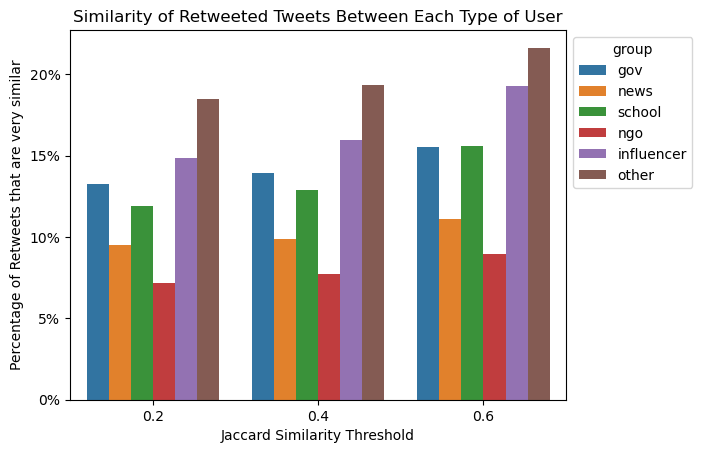

In [311]:
ax = sns.barplot(x=stackedDfRt.index,y=stackedDfRt.dupsPct,hue=stackedDfRt.group)
ax.set_title('Similarity of Retweeted Tweets Between Each Type of User')
ax.set_ylabel('Percentage of Retweets that are very similar')
ax.set_xlabel('Jaccard Similarity Threshold')
ax.set_yticklabels([f'{float(i)*100:.0f}%' for i in ax.get_yticks()])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))